### Импорт библиотек

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import roc_auc_score
import random
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go

### Создание папки, скачивание и распаковка датасета

In [5]:
!mkdir -p data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p data/ --unzip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100%|█████████████████████████████████████▉| 2.29G/2.29G [01:58<00:00, 2.79MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [01:58<00:00, 20.8MB/s]


### Распределение классов (EDA)

Train: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Val:   {'PNEUMONIA': 8, 'NORMAL': 8}
Test:  {'PNEUMONIA': 390, 'NORMAL': 234}


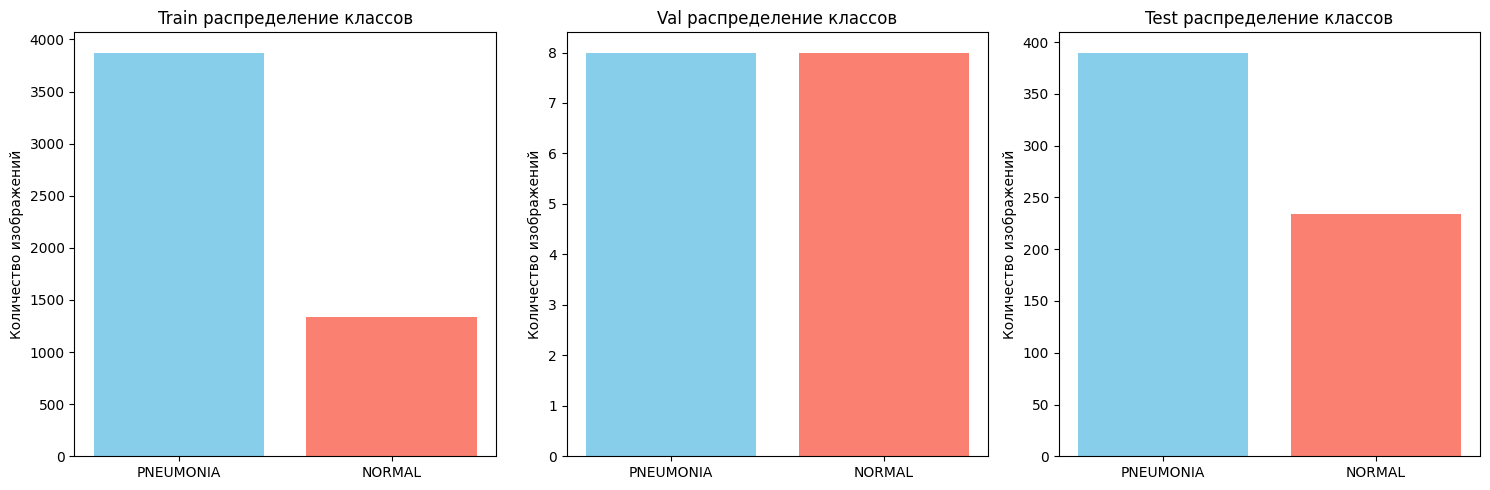

In [3]:
# пути к данным
DATA_DIR = "data/chest_xray"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

# функция для подсчёта количества изображений в каждой папке-классе
def count_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

# подсчёт количества изображений для train, val и test
train_counts = count_classes(TRAIN_DIR)
val_counts = count_classes(VAL_DIR)
test_counts = count_classes(TEST_DIR)

# вывод количества изображений по каждому классу
print("Train:", train_counts)
print("Val:  ", val_counts)
print("Test: ", test_counts)

# визуализация распределения классов
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, split, counts in zip(axs, ['Train', 'Val', 'Test'], [train_counts, val_counts, test_counts]):
    ax.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon'])
    ax.set_title(f'{split} распределение классов')
    ax.set_ylabel('Количество изображений')
    ax.set_xticks(range(len(counts)))
plt.tight_layout()
plt.show()

- Есть дисбаланс классов в обучающей и тестовой выборке

### Демонстрация датасета

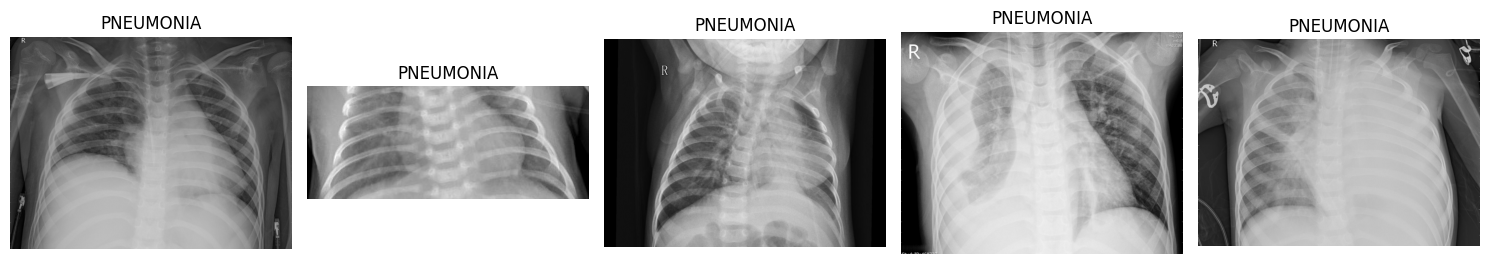

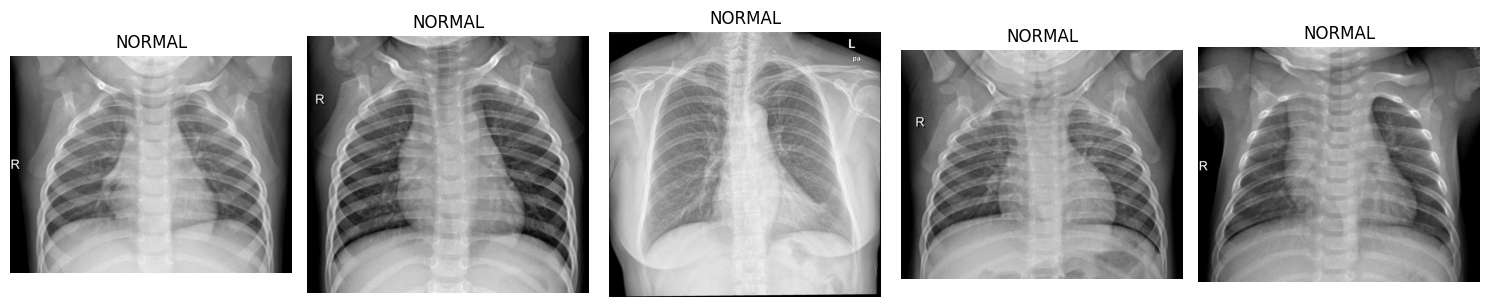

In [5]:
# функция для отображения случайных изображений из указанного класса
def show_sample_images(base_dir, class_name='PNEUMONIA', n=5):
    path = os.path.join(base_dir, class_name)  # путь к папке класса
    images = random.sample(os.listdir(path), n)  # выбор n случайных изображений

    plt.figure(figsize=(15, 3))  # создание фигуры для отображения
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)  # полный путь к изображению
        img = Image.open(img_path)  # открытие изображения
        plt.subplot(1, n, i + 1)  
        plt.imshow(img, cmap='gray')  # отображение изображения в оттенках серого
        plt.title(class_name) 
        plt.axis('off') 
    plt.tight_layout() 
    plt.show()  # отображение изображений

# отображение 5 примеров из класса PNEUMONIA
show_sample_images(TRAIN_DIR, class_name='PNEUMONIA', n=5)

# отображение 5 примеров из класса NORMAL
show_sample_images(TRAIN_DIR, class_name='NORMAL', n=5)

- Видим реальные снимки с label'ами классов

### Предобработка и аугментация

In [6]:
# размер входного изображения и размер батча
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE  # автоматическое определение числа потоков

# функция загрузки датасета из папки
def load_dataset(path, shuffle=True):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,                         # путь к папке с данными
        labels='inferred',            
        label_mode='binary',          # бинарная классификация
        image_size=(IMG_SIZE, IMG_SIZE),  # изменение размера изображений
        batch_size=BATCH_SIZE,       
        shuffle=shuffle,             
        seed=42
    )

# функция предобработки изображений для обучения
def preprocess_train(image, label):
    image = tf.image.rgb_to_grayscale(image)             # преобразование RGB в оттенки серого
    image = tf.cast(image, tf.float32) / 127.5 - 1.0      # нормализация в диапазон [-1, 1]
    image = data_augmentation(image)                      # применение аугментации
    return image, label

# функция предобработки изображений для валидации и теста
def preprocess_eval(image, label):
    image = tf.image.rgb_to_grayscale(image)             
    image = tf.cast(image, tf.float32) / 127.5 - 1.0     
    return image, label

# загрузка обучающего, валидационного и тестового датасетов
train_ds = load_dataset(TRAIN_DIR, shuffle=True)
val_ds   = load_dataset(VAL_DIR, shuffle=False)
test_ds  = load_dataset(TEST_DIR, shuffle=False)

# конфигурация аугментации изображений для обучения
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # случайное горизонтальное отражение
    tf.keras.layers.RandomRotation(0.1),       # случайное вращение
    tf.keras.layers.RandomZoom(0.1),           # случайное приближение/отдаление
])

# подготовка тренировочного датасета
train_ds = (
    train_ds
    .map(preprocess_train, num_parallel_calls=AUTOTUNE)  # применение предобработки
    .cache()                                              
    .shuffle(1000)                                        
    .prefetch(AUTOTUNE)                                   # предзагрузка батчей
)

# подготовка валидационного датасета
val_ds = (
    val_ds
    .map(preprocess_eval, num_parallel_calls=AUTOTUNE)   # предобработка без аугментации
    .cache()
    .prefetch(AUTOTUNE)
)

# подготовка тестового датасета
test_ds = (
    test_ds
    .map(preprocess_eval, num_parallel_calls=AUTOTUNE)   # предобработка без аугментации
    .cache()
    .prefetch(AUTOTUNE)
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2025-06-18 23:11:09.124381: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-06-18 23:11:09.124405: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-18 23:11:09.124411: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-06-18 23:11:09.124424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-18 23:11:09.124432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Базовая модель

In [7]:
def build_base_cnn(lr=1e-3):
    # создание модели
    net = Sequential([

        # вход: изображение 224 на 224 в градациях серого
        Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

        # сверточный блок 1
        layers.Conv2D(16, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(16, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.MaxPooling2D(pool_size=3, strides=2),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.2),

        # сверточный блок 2
        layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.MaxPooling2D(pool_size=3, strides=2),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.2),

        # сверточный блок 3
        layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.GlobalAveragePooling2D(),

        # полносвязный сегмент
        layers.Dense(128, use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.5),

        layers.Dense(64, use_bias=False),
        layers.Activation(tf.nn.gelu),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.2),

        # финальный выход — сигмоида для задачи бинарной классификации
        layers.Dense(1, activation='sigmoid')
    ])

    # компиляция модели с оптимизатором и метриками
    net.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC')
        ]
    )

    # вывод структуры модели в консоль
    net.summary()

    return net

In [8]:
EPOCHS = 15
base_model = build_base_cnn()
# обучение базовой модели на 15 эпохах
history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 16)   │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 111, 111, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 55, 55, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 55, 55, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             

 Total params: 88,977 (347.57 KB)

 Trainable params: 88,497 (345.69 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/15


2025-06-18 23:11:17.738311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - AUC: 0.8561 - accuracy: 0.7754 - loss: 0.5450 - precision: 0.9302 - recall: 0.7559 - val_AUC: 0.5703 - val_accuracy: 0.5000 - val_loss: 1.0345 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - AUC: 0.9283 - accuracy: 0.8782 - loss: 0.3164 - precision: 0.9333 - recall: 0.9014 - val_AUC: 0.5938 - val_accuracy: 0.5000 - val_loss: 1.9191 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - AUC: 0.9537 - accuracy: 0.9042 - loss: 0.2405 - precision: 0.9383 - recall: 0.9320 - val_AUC: 0.5391 - val_accuracy: 0.5625 - val_loss: 1.3242 - val_precision: 0.5385 - val_recall: 0.8750
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - AUC: 0.9582 - accuracy: 0.9100 - loss: 0.2245 - precision: 0.9353 - recall: 0.9436 - val_AUC: 0.7656 - val_accuracy: 0.5000 - val_loss: 1.7456 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━

### Вспомогательная функция для построение plotly-графика ROC-кривой

In [10]:
# выполняет оценку модели на тестовом датасете и строит ROC-кривую с метриками.
def evaluate_and_plot_roc(model, test_dataset, title='ROC Curve'):
    # сбор предсказаний и истинных меток
    y_true = []
    y_pred_proba = []

    for images, labels in test_dataset:
        probs = model.predict(images, verbose=0)
        y_pred_proba.extend(probs.flatten())
        y_true.extend(labels.numpy().flatten())

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # вычисление метрик
    test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(test_dataset, verbose=0)

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # построение графика
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name='ROC Curve',
        line=dict(width=2)
    ))

    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random guess',
        line=dict(dash='dash', color='gray')
    ))

    # аннотация с метриками
    metrics_text = (
        f"<b>Test metrics:</b><br>"
        f"Accuracy:  {test_acc:.4f}<br>"
        f"Precision: {test_prec:.4f}<br>"
        f"Recall:    {test_rec:.4f}<br>"
        f"AUC:       {roc_auc:.4f}"
    )

    fig.add_annotation(
        x=0.99, y=0.01,
        text=metrics_text,
        showarrow=False,
        align='left',
        xanchor='right',
        yanchor='bottom',
        font=dict(size=13),
        bordercolor='black',
        borderwidth=1,
        borderpad=10,
        bgcolor='white',
        opacity=0.9
    )

    # оформление графика
    fig.update_layout(
        title=title,
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        width=800,
        height=600,
        template='plotly_white',
        legend=dict(x=0.7, y=0.3),
        margin=dict(l=40, r=40, t=60, b=40)
    )

    fig.show()

In [11]:
evaluate_and_plot_roc(base_model, test_ds, title='ROC-кривая на тестовой выборке (base_model)')

2025-06-18 23:13:48.426395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- дублирование plotly-графика (png)

![ROC-кривая](base.png)

Выводы:
- Высокое значение полноты (Recall = 0.9872) указывает на то, что модель практически не пропускает случаев положительного класса. Это особенно критично в медицинских задачах, таких как диагностика заболеваний, где цена пропущенного случая может быть крайне высока. Модель демонстрирует высокую чувствительность.

- Относительно невысокая точность (Precision ≈ 0.73) свидетельствует о значительном количестве ложноположительных предсказаний. То есть модель склонна классифицировать изображения как “пневмония”, даже если это не соответствует действительности.

- Уровень общей точности (Accuracy ≈ 76%) находится на умеренном уровне. Однако при наличии дисбаланса классов данная метрика может быть недостаточно информативной, поскольку не отражает качество работы модели по каждому классу в отдельности.

- Значение площади под ROC-кривой (AUC > 0.90) указывает на высокую способность модели различать классы. Это говорит о хорошем потенциале модели в задачах ранжирования и возможности повышения общей эффективности за счёт настройки порога классификации.

In [12]:
# функция построения модели на основе MobileNetV2
def build_mobilenet_model(img_size=224, learning_rate=1e-4, base_trainable=False):
    # входной слой для изображений в градациях серого
    input_tensor = layers.Input(shape=(img_size, img_size, 1))
    
    # преобразование 1-канального изображения в 3-канальное путём копирования по каналам
    x = layers.Concatenate()([input_tensor, input_tensor, input_tensor])

    # загрузка предобученной модели MobileNetV2 без верхнего классификационного слоя
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = base_trainable  # заморозка или разморозка слоёв base_model

    # глобальное усреднение признаков
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.3)(x)  # регуляризация
    x = layers.Dense(128, activation='relu')(x)  # полносвязный слой
    x = layers.Dropout(0.2)(x)  # дополнительная регуляризация

    # выходной слой для бинарной классификации
    output = layers.Dense(1, activation='sigmoid')(x)

    # финальная модель
    model = Model(inputs=input_tensor, outputs=output)

    # компиляция модели с оптимизатором и метриками
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='AUC')
        ]
    )

    print("Модель MobileNetV2 успешно собрана.")
    model.summary()

    return model

In [13]:
IMG_SIZE = 224
EPOCHS = 15
LEARNING_RATE = 1e-4

mobile_model = build_mobilenet_model(
    img_size=IMG_SIZE,
    learning_rate=LEARNING_RATE,
    base_trainable=False
)

# обучение на 15 эпохах MobileNetV2
history = mobile_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

/var/folders/8c/pkm5cmhs3p782092gzybbqrw0000gn/T/ipykernel_44364/4187307320.py:10: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



Модель MobileNetV2 успешно собрана.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - AUC: 0.7390 - accuracy: 0.7527 - loss: 0.5304 - precision: 0.8005 - recall: 0.8857 - val_AUC: 0.9375 - val_accuracy: 0.6250 - val_loss: 0.8149 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 0.9534 - accuracy: 0.8940 - loss: 0.2425 - precision: 0.9230 - recall: 0.9349 - val_AUC: 0.9375 - val_accuracy: 0.6250 - val_loss: 0.7561 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.9685 - accuracy: 0.9222 - loss: 0.1945 - precision: 0.9427 - recall: 0.9536 - val_AUC: 0.9453 - val_accuracy: 0.7500 - val_loss: 0.6311 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 0.9712 - accuracy: 0.9249 - loss: 0.1843 - precision: 0.9473 - recall: 0.9529 - val_AUC: 0.9531 - val_accuracy: 0.7500 - val_loss: 0.5419 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/15
163/163 ━━━━━━━━━

In [14]:
evaluate_and_plot_roc(mobile_model, test_ds, title='ROC-кривая на тестовой выборке (mobile_model)')

2025-06-18 23:19:26.571351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- дублирование plotly-графика (png)

![ROC-кривая](mobile.png)

Выводы:
- Уровень общей точности составляет ~84.8%, что значительно выше по сравнению с базовой моделью. Это говорит о хорошем обобщении модели на тестовой выборке, включая оба класса.

- Точность положительных предсказаний (Precision = 0.8105)
Значение precision указывает, что около 81% всех случаев, классифицированных как «положительные» (например, пневмония), действительно таковыми являются. Таким образом, модель делает меньше ложных тревог по сравнению с базовой версией.

- Полнота (Recall = 0.9872)
Модель сохраняет высокую чувствительность — почти все положительные случаи обнаруживаются. Это особенно важно в клиническом контексте, где критично не пропустить болезнь.

- Площадь под ROC-кривой (AUC = 0.9621)
Значение AUC > 0.96 указывает на отличную способность модели различать классы. Модель уверенно ранжирует примеры по вероятности принадлежности к положительному классу.

### Общий вывод
- Модель, построенная на основе MobileNetV2, демонстрирует существенное улучшение по всем ключевым метрикам по сравнению с базовой сверточной нейронной сетью. Особенно важно, что она сохраняет высокий уровень полноты (Recall ≈ 0.99) при заметном увеличении точности (Precision > 0.81) и общей точности (Accuracy ≈ 85%)

- MobileNetV2 более предпочтительна для применения в реальной задаче